In [1]:
from dotenv import load_dotenv
import os

load_dotenv(verbose=True)
key = os.getenv('OPENAI_API_KEY')

In [2]:
from typing import Annotated, List, Dict
from typing_extensions import TypedDict
from langgraph.graph.message import add_messages

In [3]:
from langgraph.graph import StateGraph 
from langgraph.graph import START, END

In [4]:
from langgraph.prebuilt import ToolNode, tools_condition
from langchain_core.tools import tool

In [5]:
from langchain_teddynote.tools.tavily import TavilySearch
from langchain_teddynote.tools import GoogleNews

In [6]:
from langchain_openai import ChatOpenAI

In [7]:
from langchain_teddynote.graphs import visualize_graph
from langchain_teddynote.messages import display_message_tree
from langchain_core.runnables import RunnableConfig

In [8]:
from langgraph.checkpoint.memory import MemorySaver

memory = MemorySaver()

In [9]:
######### 1. 상태 정의 #########

# 상태 정의
class State(TypedDict):
    messages: Annotated[list, add_messages]

In [10]:
######### 2. 도구 정의 및 바인딩 #########

search_tool = TavilySearch(max_results=1)

In [11]:
@tool
def search_keyword(query: str) -> List[Dict[str, str]]:
    """Look up news by keyword"""
    news_tool = GoogleNews()
    return news_tool.search_by_keyword(query, k=1)

In [12]:
tools = [search_tool, search_keyword]

In [13]:
######### 3. LLM을 도구와 결합 #########

llm = ChatOpenAI(
    api_key=key, 
    model_name='gpt-4o-mini',
    temperature=0.1
)

In [14]:
llm_with_tools = llm.bind_tools(tools)

In [15]:
def chatbot(state: State):
    answer = llm_with_tools.invoke(state['messages'])

    print('=================================================================================')
    print(f'chatbot() 실행\n')
    print(f"[1] state[messages]: \n{state['messages']}\n")
    # print(f'[2] chatbot answer: \n', answer , "\n")
    print(f'[2] chatbot answer: \n', answer.content)
    print(f'[3] answer.additional_kwargs: \n', answer.additional_kwargs)
    print('=================================================================================')

    return {'messages': [answer]}

In [16]:
graph_builder = StateGraph(State)

In [17]:
graph_builder.add_node('chatbot', chatbot)

In [18]:
tool_node = ToolNode(tools=[search_tool, search_keyword])

In [19]:
graph_builder.add_node('tools', tool_node)

In [20]:
graph_builder.add_conditional_edges(
    'chatbot',
    tools_condition
)

In [21]:
######### 5. 엣지 추가 #########

# tools 에서 chatbot 으로
graph_builder.add_edge('tools', 'chatbot')

In [22]:
# START 에서 chatbot 으로
graph_builder.add_edge(START, 'chatbot')

In [23]:
# chatbot 에서 END 로
graph_builder.add_edge('chatbot', END)

In [24]:
graph = graph_builder.compile(checkpointer=memory)

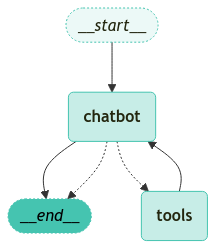

In [25]:
visualize_graph(graph)

In [28]:
from langchain.schema import HumanMessage, AIMessage
from langchain_core.messages import ToolMessage

In [29]:
config = RunnableConfig(
    recursion_limit=10, 
    configurable={'thread_id': '1'}
)

In [30]:
question = ('랭체인에 대해서 뉴스 검색을 해주세요')
# question = ('랭체인에 대해서 웹 검색을 해주세요')
# question = ('2024년 노벨 문학상 관련 뉴스를 알려주세요.')

i = 1

for event in graph.stream({"messages": [("user", question)]}, config=config):
    print('==' * 50)
    print('[event]')
    # print(event)

    for key, value in event.items():
        print(f'노드 이름 key: {key}')

        if isinstance(value['messages'][-1], HumanMessage):
            print('==================== HumanMessage ========================')
            print(f"노드 값 value: \n{value['messages'][-1]}")
            print('==================== END HumanMessage ====================')
            print() 
        elif isinstance(value['messages'][-1], AIMessage):
            print('==================== AIMessage ========================')
            print(f"노드 값 value: \n{value['messages'][-1]}")
            print('==================== END AIMessage ====================')     
            print() 
        elif isinstance(value['messages'][-1], ToolMessage):
            print('==================== ToolMessage ========================')
            print(f"노드 값 value: \n{value['messages'][-1]}")
            print('==================== END ToolMessage ====================')     
            print()

    i=i+1
    
    print('==' * 50)

chatbot() 실행

[1] state[messages]: 
[HumanMessage(content='랭체인에 대해서 뉴스 검색을 해주세요', additional_kwargs={}, response_metadata={}, id='f0ed3fff-31b4-4558-aeec-5cc135bd7463')]

[2] chatbot answer: 
 
[3] answer.additional_kwargs: 
 {'tool_calls': [{'id': 'call_7I9tNqgbCGsmTW2bMPM1dnD7', 'function': {'arguments': '{"query":"랭체인"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None}
[event]
노드 이름 key: chatbot
==================== AIMessage ========================
노드 값 value: 
content='' additional_kwargs={'tool_calls': [{'id': 'call_7I9tNqgbCGsmTW2bMPM1dnD7', 'function': {'arguments': '{"query":"랭체인"}', 'name': 'search_keyword'}, 'type': 'function'}], 'refusal': None} response_metadata={'token_usage': {'completion_tokens': 18, 'prompt_tokens': 122, 'total_tokens': 140, 'completion_tokens_details': {'accepted_prediction_tokens': 0, 'audio_tokens': 0, 'reasoning_tokens': 0, 'rejected_prediction_tokens': 0}, 'prompt_tokens_details': {'audio_tokens': 0, 'cached_tokens': 0}}, 'model